# Objective

Preparing Data in the format to be able to train  Machine Learning models that can recomend a farmer what crop to choose and also predict the yeild that a farmer can make by choosing a pirticular crop based on certain wether parameters like (temperature, humidity and rainfall) and soil parameters like (nitrogen, potassium, phosphurous ratios in soil).

# Data Availability 

- Though there is vast data across the web related agriculture the availability of labeled data in the required format tpo be able to train a ML model is very challenging to get.

- For building an MVP, we have considered datasets from kaggle that include a crop recomendation dataset (which is labeled with suitable crop for some given wether and soil parameters) and Indian Agriculture crop Production dataset (which has the information regarding yeild produced in each district in india acros the years)

# Challenges

- In crop production dataset we just have an informatioin about yeild in each district and state which will not be enough to predict the yeild that a user can get in future.

- Both the datasets are from various Sources so there are variety of crops in both the datasets which will make it difficult to pipeline the workflow. (Ex : If the first model recomends a crop that dosent exist in the 2nd dataset, then 2nd model cannot oredict the yeild)

- Un availability of soil data for each district.


# Preparing Data

## Nesessary Libraries

In [1]:
# For Data Manupulation
import pandas as pd
import numpy as np

# For Visualization
import matplotlib.pyplot as plt

# To fetch data 
import requests

## Loading Datasets

In [2]:
# Crop Recomendation Data
crop_recomendation = pd.read_csv("Initial Data/Crop_recommendation.csv")

# Crop Production Data
crop_yeild = pd.read_csv("Initial Data/India Agriculture Crop Production.csv")

# District Cordinates Data
district_cordinates = pd.read_csv("Initial Data/ApportionedIdentifiers.csv")

soil_data = pd.read_csv("Initial Data/soil_percent.csv")

## Preparing Crop Recomendation Dataset

As difference in crops in both datasets will make it difficult to pipeline the application workflow. So We have to consider only the entries with common crops in both the datasets.

In [3]:
crop_recomendation.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
crop_yeild.head()

,State,District,Crop,Year,Season,Area,Area Units,Production,Production Units,Yield
0,Andaman and Nicobar Islands,NICOBARS,Arecanut,2001-02,Kharif,1254.0,Hectare,2061.0,Tonnes,1.643541
1,Andaman and Nicobar Islands,NICOBARS,Arecanut,2002-03,Whole Year,1258.0,Hectare,2083.0,Tonnes,1.655803
2,Andaman and Nicobar Islands,NICOBARS,Arecanut,2003-04,Whole Year,1261.0,Hectare,1525.0,Tonnes,1.209358
3,Andaman and Nicobar Islands,NORTH AND MIDDLE ANDAMAN,Arecanut,2001-02,Kharif,3100.0,Hectare,5239.0,Tonnes,1.690000
4,Andaman and Nicobar Islands,SOUTH ANDAMANS,Arecanut,2002-03,Whole Year,3105.0,Hectare,5267.0,Tonnes,1.696296


Drop Null Values

In [5]:
crop_recomendation = crop_recomendation.dropna()
crop_yeild = crop_yeild.dropna()

Conovert the labels in crop recomendation data and Crops in Crop production data to lower case to get the common crops

In [6]:
crop_recomendation['label'] = crop_recomendation['label'].str.lower()
crop_yeild['Crop'] = crop_yeild['Crop'].str.lower()

Get the list of Crops in both the datasets

In [7]:
crops_inrecomend = crop_recomendation['label'].unique().tolist()
crops_inyeild = crop_yeild['Crop'].unique().tolist()

print(f"There are {len(crops_inrecomend)} crops in Crop Recomendation Dataset")
print(f"There are {len(crops_inyeild)} crops in Crop Production Dataset")

There are 22 crops in Crop Recomendation Dataset
There are 56 crops in Crop Production Dataset


#### Remove the crops that are Unique to each dataset

In [8]:
common_crops = set(crops_inyeild).intersection(set(crops_inrecomend))

print(f"There are {len(common_crops)} in common to both the datasets :")
print(common_crops)

There are 5 in common to both the datasets :
{'maize', 'banana', 'rice', 'coconut', 'jute'}


Removing Uncommon Crops

In [9]:
crop_recomend_filtered  = crop_recomendation[crop_recomendation['label'].isin(common_crops)]
crop_yeild_filtered = crop_yeild[crop_yeild['Crop'].isin(common_crops)]

In [10]:
rows_deleted1 = len(crop_recomendation)- len(crop_recomend_filtered)
rows_deleted2 = len(crop_yeild) - len(crop_yeild_filtered)

print(f"{rows_deleted1} Entries from Crop Recomendation dataset are removed")
print(f"{rows_deleted2} Entries from Crop Yeild Dataset are removed")

1700 Entries from Crop Recomendation dataset are removed
289391 Entries from Crop Yeild Dataset are removed


In [11]:
print(len(crop_recomend_filtered))
print(len(crop_yeild_filtered))

500
51023


Save the Prepared Crop Recomendation Dataset

In [13]:
crop_recomend_filtered.to_csv("Extracted Data/Updated_CropRecomendation.csv",index=False)

### Observation

- There are 5 crops (banana, coconut, maize, jute, rice) that are common to both the datasets

- After removing the uncommon crops, there are 500 rows left in Crop Recomendation dataset and 51023 rows left in Crop Production Dataset

- Preparation Crop Recomendation is done and can be used to train Crop Recomendatioin Model

## Preparing Crop Production Dataset

As the information available in Crop Production dataset in insufficent to prepare a working ML model that can predict yeild we have to get the wether data for each district for the given specific time and soil data based on the state.

### Adding Soil Data

In [14]:
soil_data.head()

,State,Nitrogen - High,Nitrogen - Medium,Nitrogen - Low,Phosphorous - High,Phosphorous - Medium,Phosphorous - Low,Potassium - High,Potassium - Medium,Potassium - Low,OC - Sufficient,OC - Deficient,EC - Saline,EC - Non Saline,pH - Acidic,pH - Neutral,pH - Alkaline
0,ANDHRA PRADESH,0.17286084701815038%,17.63180639585134%,82.19533275713052%,1.1882998171846435%,70.74954296160878%,28.062157221206583%,82.69581056466302%,16.21129326047359%,1.092896174863388%,39.273356401384085%,60.726643598615915%,16.14853195164076%,83.85146804835924%,2.0725388601036268%,35.66493955094992%,62.26252158894646%
1,ASSAM,6.53138871274572%,93.46861128725428%,0%,0%,100%,0%,26.484886916085394%,49.14394419784401%,24.3711688860706%,34.474741069541324%,65.52525893045868%,0.4861551469034031%,99.5138448530966%,9.554005495666878%,87.80384696681463%,2.642147537518495%
2,BIHAR,2.0120724346076457%,29.848657160353426%,68.13927040503893%,17.130358705161854%,81.10236220472441%,1.7672790901137359%,58.930602957906714%,37.99772468714448%,3.0716723549488054%,76.88309400052859%,23.116905999471413%,30.23215968474257%,69.76784031525743%,5.412198391420912%,56.459450402144775%,38.12835120643432%
3,CHHATTISGARH,0.22256886318672958%,25.658195099680412%,74.11923603713285%,0.6278985438097601%,79.68776838368609%,19.684333072504153%,77.29510073260073%,20.34302503052503%,2.361874236874237%,52.14730942986218%,47.85269057013782%,25.82495046486816%,74.17504953513183%,49.88817681219343%,43.07354019056926%,7.038282997237309%
4,DELHI,0%,0%,100%,7.6923076923076925%,46.15384615384615%,46.15384615384615%,25%,8.333333333333334%,66.66666666666667%,100%,0%,61.53846153846154%,38.46153846153846%,46.666666666666664%,26.666666666666668%,26.666666666666668%


Remove percentage symbol for further analysis

In [15]:
# Function to remove % symbol and convert to float
def remove_percent(value):
    return float(value.strip('%'))

# Remove % symbol and convert to float for all columns except 'State'
for col in soil_data.columns[1:]:
    soil_data[col] = soil_data[col].apply(remove_percent)

In [16]:
soil_data.head()

,State,Nitrogen - High,Nitrogen - Medium,Nitrogen - Low,Phosphorous - High,Phosphorous - Medium,Phosphorous - Low,Potassium - High,Potassium - Medium,Potassium - Low,OC - Sufficient,OC - Deficient,EC - Saline,EC - Non Saline,pH - Acidic,pH - Neutral,pH - Alkaline
0,ANDHRA PRADESH,0.172861,17.631806,82.195333,1.188300,70.749543,28.062157,82.695811,16.211293,1.092896,39.273356,60.726644,16.148532,83.851468,2.072539,35.664940,62.262522
1,ASSAM,6.531389,93.468611,0.000000,0.000000,100.000000,0.000000,26.484887,49.143944,24.371169,34.474741,65.525259,0.486155,99.513845,9.554005,87.803847,2.642148
2,BIHAR,2.012072,29.848657,68.139270,17.130359,81.102362,1.767279,58.930603,37.997725,3.071672,76.883094,23.116906,30.232160,69.767840,5.412198,56.459450,38.128351
3,CHHATTISGARH,0.222569,25.658195,74.119236,0.627899,79.687768,19.684333,77.295101,20.343025,2.361874,52.147309,47.852691,25.824950,74.175050,49.888177,43.073540,7.038283
4,DELHI,0.000000,0.000000,100.000000,7.692308,46.153846,46.153846,25.000000,8.333333,66.666667,100.000000,0.000000,61.538462,38.461538,46.666667,26.666667,26.666667


#### Getting Ratio of Nutrients 

To derive a single representative value for nutrient for each state, you can use a weighted average approach. This approach takes into account the proportion of soil samples in each category (high, medium, low) and their respective nutrient levels.

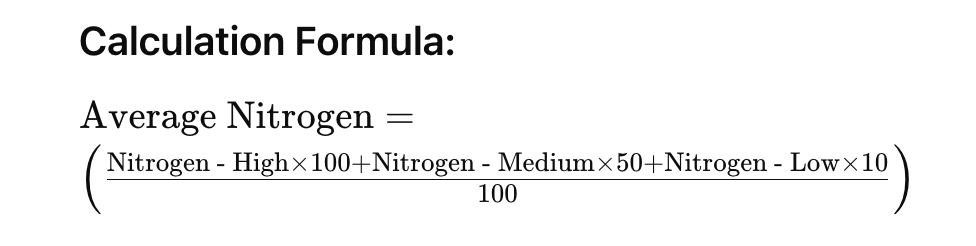

In [17]:
nitrogen_high_value = 100
nitrogen_medium_value = 50
nitrogen_low_value = 10

soil_data['Avg_Nitrogen'] = (
    soil_data['Nitrogen - High'] * nitrogen_high_value +
    soil_data['Nitrogen - Medium'] * nitrogen_medium_value +
    soil_data['Nitrogen - Low'] * nitrogen_low_value
) / 100

In [18]:
# Representative values for Phosphorous and Potassium
phosphorous_high_value = 30
phosphorous_medium_value = 15
phosphorous_low_value = 5

# Calculate average phosphorous and potassium values
soil_data['Avg_Phosphorous'] = (
    soil_data['Phosphorous - High'] * phosphorous_high_value +
    soil_data['Phosphorous - Medium'] * phosphorous_medium_value +
    soil_data['Phosphorous - Low'] * phosphorous_low_value
) / 100

In [19]:
potassium_high_value = 300
potassium_medium_value = 150
potassium_low_value = 50

soil_data['Avg_Potassium'] = (
    soil_data['Potassium - High'] * potassium_high_value +
    soil_data['Potassium - Medium'] * potassium_medium_value +
    soil_data['Potassium - Low'] * potassium_low_value
) / 100

Remove unwanted Columns 

In [20]:
columns_to_remove = [
    'Nitrogen - High', 'Nitrogen - Medium', 'Nitrogen - Low',
    'Phosphorous - High', 'Phosphorous - Medium', 'Phosphorous - Low',
    'Potassium - High', 'Potassium - Medium', 'Potassium - Low',
    'OC - Sufficient', 'OC - Deficient', 'EC - Saline', 'EC - Non Saline'
]

soil_data.drop(columns=columns_to_remove, inplace=True)

In [21]:
soil_data.head()

,State,pH - Acidic,pH - Neutral,pH - Alkaline,Avg_Nitrogen,Avg_Phosphorous,Avg_Potassium
0,ANDHRA PRADESH,2.072539,35.664940,62.262522,17.208297,12.372029,272.950820
1,ASSAM,9.554005,87.803847,2.642148,53.265694,15.000000,165.356161
2,BIHAR,5.412198,56.459450,38.128351,23.750328,17.392826,235.324232
3,CHHATTISGARH,49.888177,43.073540,7.038283,20.463590,13.125751,263.580777
4,DELHI,46.666667,26.666667,26.666667,10.000000,11.538462,120.833333


#### Getting singular pH value 



To change the pH values to a single column within the range of 0-14, we need to combine the pH - Acidic, pH - Neutral, and pH - Alkaline columns into one. A straightforward approach is to create a weighted average pH value based on the proportions given by these three columns.

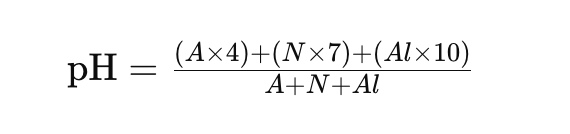

In [22]:
soil_data['pH'] = (soil_data['pH - Acidic'] * 4 + soil_data['pH - Neutral'] * 7 + soil_data['pH - Alkaline'] * 10) / (soil_data['pH - Acidic'] + soil_data['pH - Neutral'] + soil_data['pH - Alkaline'])

Remove Unwanted Columns

In [23]:
soil_data.drop(columns=['pH - Acidic', 'pH - Neutral', 'pH - Alkaline'], inplace=True)

In [24]:
soil_data.head()

,State,Avg_Nitrogen,Avg_Phosphorous,Avg_Potassium,pH
0,ANDHRA PRADESH,17.208297,12.372029,272.950820,8.805699
1,ASSAM,53.265694,15.000000,165.356161,6.792644
2,BIHAR,23.750328,17.392826,235.324232,7.981485
3,CHHATTISGARH,20.463590,13.125751,263.580777,5.714503
4,DELHI,10.000000,11.538462,120.833333,6.400000


Save this data for further Use 

In [25]:
soil_data.to_csv("Extracted Data/statewise_soil_data.csv",index=False)

#### Append this soil Data with Crop Production Data

Convert State to lower case in both crop production data and soil data

In [26]:
soil_data['State'] = soil_data['State'].str.lower()
crop_yeild_filtered['State'] = crop_yeild_filtered['State'].str.lower()

/var/folders/yd/6l3qbbqj2qx_y_lxrr45xd480000gn/T/ipykernel_45276/1011393577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_yeild_filtered['State'] = crop_yeild_filtered['State'].str.lower()


Get the list of States in each dataset

In [27]:
states_incropyeild = crop_yeild_filtered['State'].unique().tolist()
states_insoil = soil_data['State'].unique().tolist()

print(f"There are {len(states_incropyeild)} States in Crop Production Dataset")
print(f"There are {len(states_insoil)} States in Soil Dataset")

There are 35 States in Crop Production Dataset
There are 22 States in Soil Dataset


Remove States that are unique to each dataset

In [28]:
common_states = set(states_incropyeild).intersection(set(states_insoil))

print(f"There are {len(common_states)} in common to both the datasets :")
print(common_states)

There are 21 in common to both the datasets :
{'delhi', 'uttar pradesh', 'goa', 'telangana', 'gujarat', 'west bengal', 'tripura', 'jharkhand', 'rajasthan', 'bihar', 'chhattisgarh', 'punjab', 'himachal pradesh', 'nagaland', 'assam', 'maharashtra', 'uttarakhand', 'andhra pradesh', 'tamil nadu', 'madhya pradesh', 'mizoram'}


Remove Uncommon States

In [29]:
soil_data_filtered  = soil_data[soil_data['State'].isin(common_states)]
crop_yeild_filtered_soil = crop_yeild_filtered[crop_yeild_filtered['State'].isin(common_states)]

In [30]:
rows_deleted1 = len(soil_data)- len(soil_data_filtered)
rows_deleted2 = len(crop_yeild_filtered) - len(crop_yeild_filtered_soil)

print(f"{rows_deleted1} Entries from Crop Recomendation dataset are removed")
print(f"{rows_deleted2} Entries from Crop Yeild Dataset are removed")

1 Entries from Crop Recomendation dataset are removed
13261 Entries from Crop Yeild Dataset are removed


In [31]:
print(len(soil_data_filtered))
print(len(crop_yeild_filtered_soil))

21
37762


Merge Two Datasets ON State

In [32]:
crop_yeild_with_soil = pd.merge(crop_yeild_filtered_soil, soil_data_filtered, on="State")
crop_yeild_with_soil.head()

,State,District,Crop,Year,Season,Area,Area Units,Production,Production Units,Yield,Avg_Nitrogen,Avg_Phosphorous,Avg_Potassium,pH
0,andhra pradesh,ADILABAD,banana,2001-02,Whole Year,225.0,Hectare,5063.0,Tonnes,22.502222,17.208297,12.372029,272.95082,8.805699
1,andhra pradesh,ADILABAD,banana,2002-03,Whole Year,13.0,Hectare,317.0,Tonnes,24.384615,17.208297,12.372029,272.95082,8.805699
2,andhra pradesh,ADILABAD,banana,2003-04,Whole Year,110.0,Hectare,1540.0,Tonnes,14.000000,17.208297,12.372029,272.95082,8.805699
3,andhra pradesh,ANANTAPUR,banana,2001-02,Whole Year,1582.0,Hectare,462.0,Tonnes,0.292035,17.208297,12.372029,272.95082,8.805699
4,andhra pradesh,ANANTAPUR,banana,2002-03,Whole Year,19.0,Hectare,1006.0,Tonnes,52.947368,17.208297,12.372029,272.95082,8.805699


In [33]:
len(crop_yeild_with_soil)

37762

### Adding wether conditions corresponding to the yeild produced

- We have a API powered by NASA that can fetch the wether conditions like temperature, humidity, rainfall of the given district at the tie period mentioned so we can get the wether conditions supported to produce the given yeild to train our model.

- As this API needs cordinates of the pirticular area to fetchthe wether data we have to get the cordinates of each district

#### Getting cordinates of the districts to required to fetch the wether conditions corresponding to it

In [34]:
district_cordinates.head()

,State Code,Indian Census State Code 2011,State Name,District Code,Indian Census District Code 2011,District Name,ICRISAT Indian Id,SAT/NONSAT District,Region Code,Region Name,Agro Ecological Zones ICRISAT,Agro Ecological Zones NATP,AEZ Production Zones NATP,Latitude,Longitude
0,14,22,Chhattisgarh,1,409,Durg,1013,1,2,Durg division,3,5,5.1,21.2,81.3
1,14,22,Chhattisgarh,2,414,Bastar,1002,2,1,Bastar division,1,5,5.1,19.1,82.0
2,14,22,Chhattisgarh,3,410,Raipur,1027,1,3,Raipur division,3,5,5.1,21.2,81.7
3,14,22,Chhattisgarh,4,406,Bilaspur,1006,1,4,Bilaspur division,3,5,5.1,22.1,82.1
4,14,22,Chhattisgarh,5,403,Raigarh,1026,1,4,Bilaspur division,3,5,5.1,21.9,83.4


Extract Required Data

In [35]:
district_cordinates = district_cordinates[['District Name', 'Latitude','Longitude']]
district_cordinates.head()

,District Name,Latitude,Longitude
0,Durg,21.2,81.3
1,Bastar,19.1,82.0
2,Raipur,21.2,81.7
3,Bilaspur,22.1,82.1
4,Raigarh,21.9,83.4


We have to renmove entries Unique Ocuurence of district in either of the datasets

In [36]:
district_cordinates['District Name'] = district_cordinates['District Name'].str.lower()
crop_yeild_with_soil['District'] = crop_yeild_with_soil['District'].str.lower()

In [37]:
district_latlong = district_cordinates['District Name'].unique().tolist()
district_yeild = crop_yeild_with_soil['District'].unique().tolist()

print(f"There are {len(district_latlong)} Districts in District Cordinates dataset")
print(f"There are {len(district_yeild)} Districts in Crop Production Dataset")

There are 313 Districts in District Cordinates dataset
There are 535 Districts in Crop Production Dataset


In [38]:
common_districts = set(district_yeild).intersection(set(district_latlong))
print(f"There are {len(common_districts)} in Both the the datasets")

There are 209 in Both the the datasets


In [39]:
district_cordinates_filtered = district_cordinates[district_cordinates['District Name'].isin(common_districts)]
crop_yeild_refiltered = crop_yeild_with_soil[crop_yeild_with_soil['District'].isin(common_districts)]

In [40]:
rows_deleted1 = len(district_cordinates)- len(district_cordinates_filtered)
rows_deleted2 = len(crop_yeild_with_soil) - len(crop_yeild_refiltered)

print(f"{rows_deleted1} Entries from District Cordinates dataset are removed")
print(f"{rows_deleted2} Entries from Crop Yeild Dataset are removed")

104 Entries from District Cordinates dataset are removed
21651 Entries from Crop Yeild Dataset are removed


In [41]:
len(crop_yeild_refiltered)

16111

#### Merge two datasets to get location information of each district

In [42]:
district_cordinates_filtered = district_cordinates_filtered.rename(columns={"District Name": "District"})

In [43]:
crop_yeild_merged = pd.merge(crop_yeild_refiltered, district_cordinates_filtered, on="District")

crop_yeild_merged.head()

,State,District,Crop,Year,Season,Area,Area Units,Production,Production Units,Yield,Avg_Nitrogen,Avg_Phosphorous,Avg_Potassium,pH,Latitude,Longitude
0,andhra pradesh,adilabad,banana,2001-02,Whole Year,225.0,Hectare,5063.0,Tonnes,22.502222,17.208297,12.372029,272.95082,8.805699,19.4,79.3
1,andhra pradesh,adilabad,banana,2002-03,Whole Year,13.0,Hectare,317.0,Tonnes,24.384615,17.208297,12.372029,272.95082,8.805699,19.4,79.3
2,andhra pradesh,adilabad,banana,2003-04,Whole Year,110.0,Hectare,1540.0,Tonnes,14.000000,17.208297,12.372029,272.95082,8.805699,19.4,79.3
3,andhra pradesh,anantapur,banana,2001-02,Whole Year,1582.0,Hectare,462.0,Tonnes,0.292035,17.208297,12.372029,272.95082,8.805699,14.6,77.0
4,andhra pradesh,anantapur,banana,2002-03,Whole Year,19.0,Hectare,1006.0,Tonnes,52.947368,17.208297,12.372029,272.95082,8.805699,14.6,77.0


In [44]:
len(crop_yeild_merged)

16111

Get start and end year required to fetch data from NASA API

In [45]:
# Extract the start year as integers
crop_yeild_merged['Start_Year'] = crop_yeild_merged['Year'].str[:4].astype(int)

# Extract the end year by adding the last two digits to the start year
crop_yeild_merged['End_Year'] = crop_yeild_merged['Start_Year'] + crop_yeild_merged['Year'].str[5:].astype(int) - crop_yeild_merged['Start_Year']%100

In [46]:
col = ['Year']
crop_yeild_merged.drop(columns=col,inplace=True)

In [47]:
crop_yeild_merged.head()

,State,District,Crop,Season,Area,Area Units,Production,Production Units,Yield,Avg_Nitrogen,Avg_Phosphorous,Avg_Potassium,pH,Latitude,Longitude,Start_Year,End_Year
0,andhra pradesh,adilabad,banana,Whole Year,225.0,Hectare,5063.0,Tonnes,22.502222,17.208297,12.372029,272.95082,8.805699,19.4,79.3,2001,2002
1,andhra pradesh,adilabad,banana,Whole Year,13.0,Hectare,317.0,Tonnes,24.384615,17.208297,12.372029,272.95082,8.805699,19.4,79.3,2002,2003
2,andhra pradesh,adilabad,banana,Whole Year,110.0,Hectare,1540.0,Tonnes,14.000000,17.208297,12.372029,272.95082,8.805699,19.4,79.3,2003,2004
3,andhra pradesh,anantapur,banana,Whole Year,1582.0,Hectare,462.0,Tonnes,0.292035,17.208297,12.372029,272.95082,8.805699,14.6,77.0,2001,2002
4,andhra pradesh,anantapur,banana,Whole Year,19.0,Hectare,1006.0,Tonnes,52.947368,17.208297,12.372029,272.95082,8.805699,14.6,77.0,2002,2003


#### Add wether data 

We use NASA's API to get the historical wether data (temperature, humidity, rainfall) of a place over specific period of time

Parameters :
- Start Year
- End Year
- Latitude
- Longitude

In [48]:
def get_weather_data(row):
    url = f"https://power.larc.nasa.gov/api/temporal/monthly/point?start={row['Start_Year']}&end={row['End_Year']}&latitude={row['Latitude']}&longitude={row['Longitude']}&community=ag&parameters=TS,QV2M,PRECTOTCORR_SUM&format=json&user=TEST&header=true"
    
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        ts_values = list(data['properties']['parameter']['TS'].values())
        qv2m_values = list(data['properties']['parameter']['QV2M'].values())
        prectotcorr_values = list(data['properties']['parameter']['PRECTOTCORR_SUM'].values())
        
        avg_ts = sum(ts_values) / len(ts_values) if ts_values else None
        avg_qv2m = sum(qv2m_values)/len(qv2m_values) if qv2m_values else None
        avg_prectotcorr = sum(prectotcorr_values)/len(prectotcorr_values) if prectotcorr_values else None
        
        # print(f"Extracted")
        return pd.Series({'temperature': avg_ts, 'humidity': avg_qv2m, 'rainfall': avg_prectotcorr})
    else:
        print(f"Could not get wether details of the region")
        return pd.Series({'temperature': None, 'humidity': None, 'rainfall': None})

Processing all the 16000 rows might be time taking so we devide it into chunks and process each chunk and combine them

In [ ]:
final_data = pd.DataFrame()

In [ ]:
chunk_size = 500
# Calculate the number of chunks
num_chunks = len(crop_yeild_merged) // chunk_size + (len(crop_yeild_merged) % chunk_size != 0)

In [ ]:
for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = start_index + chunk_size
    chunk = crop_yeild_merged.iloc[start_index:end_index]

    chunk[['temperature','humidity','rainfall']] = chunk.apply(get_weather_data, axis=1)

    final_data = pd.concat([final_data, chunk], ignore_index=True)

    final_data.to_csv("/kaggle/working/final_yeild_data.csv", index=False)